# Imports


In [14]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import data

In [5]:
# raw_data6 = pd.read_csv('data/scenario6.labeled', delimiter='\s+')
raw_data10 = pd.read_csv('data/scenario10.labeled', delimiter='\s+')

In [6]:
def parse_data(raw):
    data = raw
    data['Date'] = data['Date'].map(str) + " " + data['flow']

    src_ip_port = data['Prot'].map(str).str.split(':', n=1, expand = True)
    dst_ip_port = data['IP'].map(str).str.split(':', n=1, expand = True)
    data['src_ip'] = src_ip_port[0]
    data['src_port'] = src_ip_port[1]
    data['dst_ip'] = dst_ip_port[0]
    data['dst_port'] = dst_ip_port[1]

    data.drop(['flow', 'Src','Packets', 'Bytes', 'Flows', 'Prot', 'IP', 'Label', 'Labels'], axis=1, inplace=True)
    data.rename(columns={'start':'duration', 'Date':'start','Durat':'protocol', 'Addr:Port':'flags', 'Dst':'tos', 'IP.1':'packets', 'Addr:Port.1':'bytes', 'Flags':'flows', 'Tos':'label'}, inplace=True)
    data.sort_values(by='start', inplace=True)
    data['protocol_cat'] = pd.Categorical(data['protocol'], categories=data['protocol'].unique()).codes
    data['label_num'] = data['label'].apply(lambda x: 1 if x == 'Botnet' else 0)
    
    return data

In [4]:
# data6 = parse_data(raw_data6)
# print(data6.head())
# print(data6['label'].unique())

In [7]:
data10 = parse_data(raw_data10)
print(data10.head())
print(data10['label'].unique())

                     start  duration protocol  flags  tos  packets    bytes  \
0  2011-08-18 10:19:13.328     0.002      TCP  FRPA_    0        4      321   
1  2011-08-18 10:19:13.328     4.995      UDP    INT    0      617    40095   
2  2011-08-18 10:19:13.329     4.996      UDP    INT    0     1290  1909200   
3  2011-08-18 10:19:13.330     0.000      TCP     A_    0        1       66   
4  2011-08-18 10:19:13.330     0.000      TCP   FPA_    0        2      169   

   flows       label          src_ip src_port          dst_ip dst_port  \
0      1  Background   147.32.86.166    33426  212.24.150.110    25443   
1      1  Background     82.39.2.249    41915    147.32.84.59    43087   
2      1  Background    147.32.84.59    43087     82.39.2.249    41915   
3      1  Background   147.32.86.166    42020   147.32.192.34      993   
4      1  Background  212.24.150.110    25443   147.32.86.166    33426   

   protocol_cat  label_num  
0             0          0  
1             1       

# Flow data discretization task

In [8]:
infected_ip = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193', '147.32.84.204', '147.32.84.205', '147.32.84.206', '147.32.84.207', '147.32.84.208', '147.32.84.209']
selected_infected = 0

normal_ip = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

infected_data = data10[(data10['src_ip']== infected_ip[selected_infected])]
normal_data = data10[data10['src_ip'].isin(normal_ip)]

In [7]:
def print_stat(feature):
    print(feature + "   -   Infected   -   Mean: " + str(round(infected_data[feature].mean(),2)) + "     Std: " + str(round(infected_data[feature].std(),2)))
    print(feature + "   -   Normal     -   Mean: " + str(round(normal_data[feature].mean(),2)) + "     Std: " + str(round(normal_data[feature].std(),2)))

In [8]:
for feature in data10.select_dtypes([np.number]).columns:
    print_stat(feature)

duration   -   Infected   -   Mean: 0.55     Std: 1.44
duration   -   Normal     -   Mean: 0.03     Std: 0.31
tos   -   Infected   -   Mean: 0.0     Std: 0.0
tos   -   Normal     -   Mean: 0.0     Std: 0.0
packets   -   Infected   -   Mean: 15.84     Std: 102.15
packets   -   Normal     -   Mean: 1.77     Std: 33.22
bytes   -   Infected   -   Mean: 14104.12     Std: 84291.2
bytes   -   Normal     -   Mean: 781.56     Std: 34258.15
flows   -   Infected   -   Mean: 1.0     Std: 0.0
flows   -   Normal     -   Mean: 1.0     Std: 0.0
protocol_cat   -   Infected   -   Mean: 1.94     Std: 0.31
protocol_cat   -   Normal     -   Mean: 0.94     Std: 0.24
label_num   -   Infected   -   Mean: 1.0     Std: 0.0
label_num   -   Normal     -   Mean: 0.0     Std: 0.02


In [9]:
def plot_feature(feature1, feature2):
    plt.figure(figsize=(15,5))
    plt.scatter(infected_data[feature1], infected_data[feature2], label='infected_data')
    plt.scatter(normal_data[feature1], normal_data[feature2], label='normal_data')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend()
    plt.show()

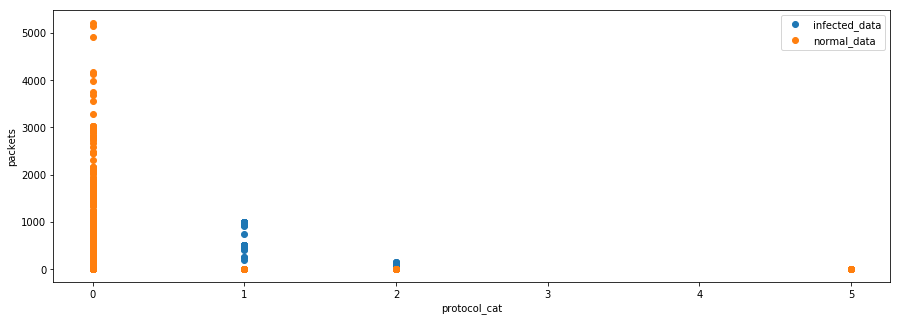

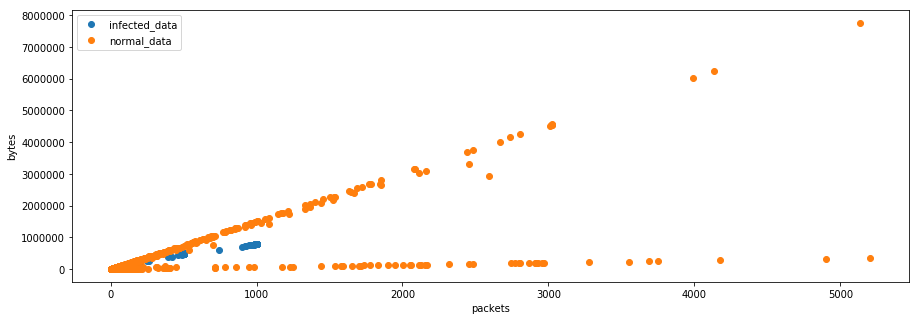

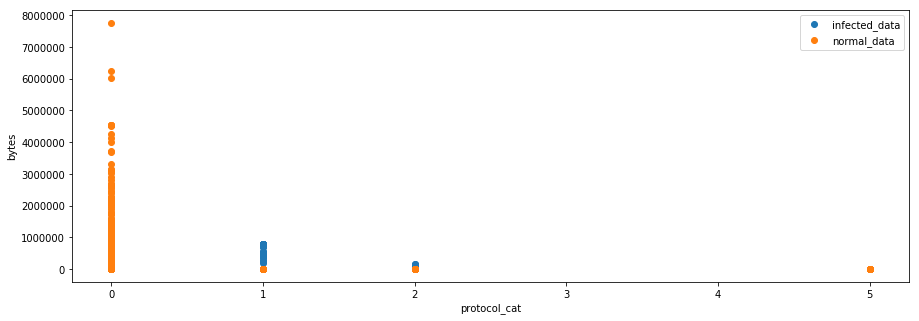

In [10]:
# plot_feature('duration', 'packets')
plot_feature('protocol_cat', 'packets')
plot_feature('packets', 'bytes')
plot_feature('protocol_cat', 'bytes')

In [11]:
class map_numerical:
    def __init__(self, data, feature, num_percentiles = 5):
        self.data = data[feature].reset_index(drop=True)
        self.percentiles = np.arange(1/num_percentiles, 1, 1/num_percentiles)
        self.percentiles_values = list(map(lambda x: np.percentile(self.data,x*100), self.percentiles))
        self.num_percentiles = num_percentiles
        
    def mapping(self, row):
        value = self.data[row]
        previous_boundary = 0
        for i,boundary in enumerate(self.percentiles_values):
            if value >= previous_boundary and value < boundary:
                return i
            previous_boundary = boundary
        return self.num_percentiles - 1
    
    def mapping_size(self):
        return self.num_percentiles

In [12]:
class map_categorical:
    def __init__(self, data, feature):
        self.data = data[feature].reset_index(drop=True)
        self.categories = self.data.unique()
        self.num_categories = self.data.nunique()
        
    def mapping(self, row):
        value = self.data[row]
        return np.where(self.categories == value)[0][0]
    
    def mapping_size(self):
        return self.num_categories

In [13]:
def encode_netflow(features, row):
    code = 0
    space_size = 1
    for feature in features:
        space_size *= feature.mapping_size()
    for feature in features:
        mapping_size = feature.mapping_size()
        code += feature.mapping(row) * space_size / mapping_size
        space_size /= mapping_size
    return code

In [14]:
def encode_series(features, num_rows):
    encoded = list()
    for i in range(0, num_rows):
        encoded.append(encode_netflow(features, i))
    return encoded

In [15]:
limit = min(len(infected_data), len(normal_data))

inf_proto = map_categorical(infected_data, 'protocol')
inf_byte = map_numerical(infected_data, 'bytes')
inf_encoded_serie = encode_series([inf_proto,inf_byte], limit)

norm_proto = map_categorical(normal_data, 'protocol')
norm_byte = map_numerical(normal_data, 'bytes')
norm_encoded_serie = encode_series([norm_proto,norm_byte], limit)

In [16]:
plt.figure(figsize=(15,5))
plt.plot(norm_encoded_serie, label="Normal data")
plt.plot(inf_encoded_serie, label="Infected data")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [34]:
all_proto = map_categorical(data10, 'protocol')
all_byte = map_numerical(data10, 'bytes')
all_encoded_serie = encode_series([all_proto,all_byte], len(data10))

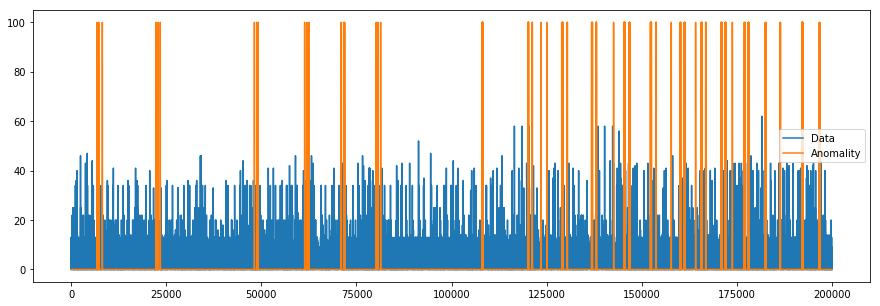

In [33]:
start = 700000
end = 800000
plt.figure(figsize=(15,5))
plt.plot(all_encoded_serie[start:end], label="Data")
plt.plot(range(0, end-start), data10['label_num'][start:end]*100, label="Anomality")
plt.legend()
plt.show()

In [ ]:
# prepare for sliding window
hosts = infected_ip + normal_ip
hosts.pop(selected_infected)
data10['discretize'] = all_encoded_serie

for ip in hosts:
    print(data10[data10['src_ip']==ip]['discretize'].head())

384290    5.0
384884    6.0
384890    3.0
385572    6.0
385576    7.0
Name: discretize, dtype: float64
574744    5.0
575404    6.0
575409    3.0
576181    6.0
576187    7.0
Name: discretize, dtype: float64
